In [1]:
import os
import tensorflow as tf

BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (224, 224)
SEED = 42

def extract_family_genus_and_species_from_path(path):
    # TensorFlow operation to extract the folder name from the full path
    parts = tf.strings.split(path, os.sep)
    folder_name = parts[
        -2
    ]  # Assumes the structure '/.../family_genus_species/image.jpg'

    # Split the folder name assuming the format "family_genus_species"
    family_genus_species = tf.strings.split(folder_name, "_")
    family = family_genus_species[-3]
    genus = family_genus_species[-2]
    species = family_genus_species[-2] + " " + family_genus_species[-1]

    return family, genus, species

def process_path(path, family_labels, genus_labels, species_labels):
    # Load the raw data from the file as a string
    img = tf.io.read_file(path)

    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image to the desired size
    img = tf.image.resize(img, [224, 224])

    # Get the family, genus, and species labels
    family, genus, species = extract_family_genus_and_species_from_path(path)

    # Convert family, genus, and species to indices
    family_label = tf.argmax(tf.equal(family_labels, family))
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))

    # Convert to one-hot encoded format
    family_label = tf.one_hot(family_label, len(family_labels))
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    # Return the image and a dictionary of labels with matching keys
    return img, {
        "family": family_label,
        "genus": genus_label,
        "species": species_label
    }

def build_dataset(directory, batch_size=32):
    # Get list of all files and extract labels
    file_paths = []
    family_labels = set()
    genus_labels = set()
    species_labels = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

                # Extract family, genus, and species
                folder_name = os.path.basename(os.path.dirname(file_path))
                family, genus, species = folder_name.split("_")

                species = genus + " " + species

                # Collect unique family, genus, and species names
                family_labels.add(family)
                genus_labels.add(genus)
                species_labels.add(species)

    # Convert sets to sorted lists to keep label indices consistent
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    # Create a TensorFlow dataset from the file paths
    path_ds = tf.data.Dataset.from_tensor_slices(file_paths)

    # Convert family, genus, and species labels to TensorFlow tensors
    family_labels = tf.constant(family_labels)
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(
        lambda x: process_path(x, family_labels, genus_labels, species_labels),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(file_paths))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return (
        image_label_ds,
        family_labels.numpy().tolist(),
        genus_labels.numpy().tolist(),
        species_labels.numpy().tolist(),
    )

# Usage
train_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/train"
)
val_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid"
)
test_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test"
)

2024-10-22 09:38:28.239249: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-22 09:38:28.239275: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-22 09:38:28.239280: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-22 09:38:28.239293: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-22 09:38:28.239304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [3]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)

2024-10-22 09:38:39.746404: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


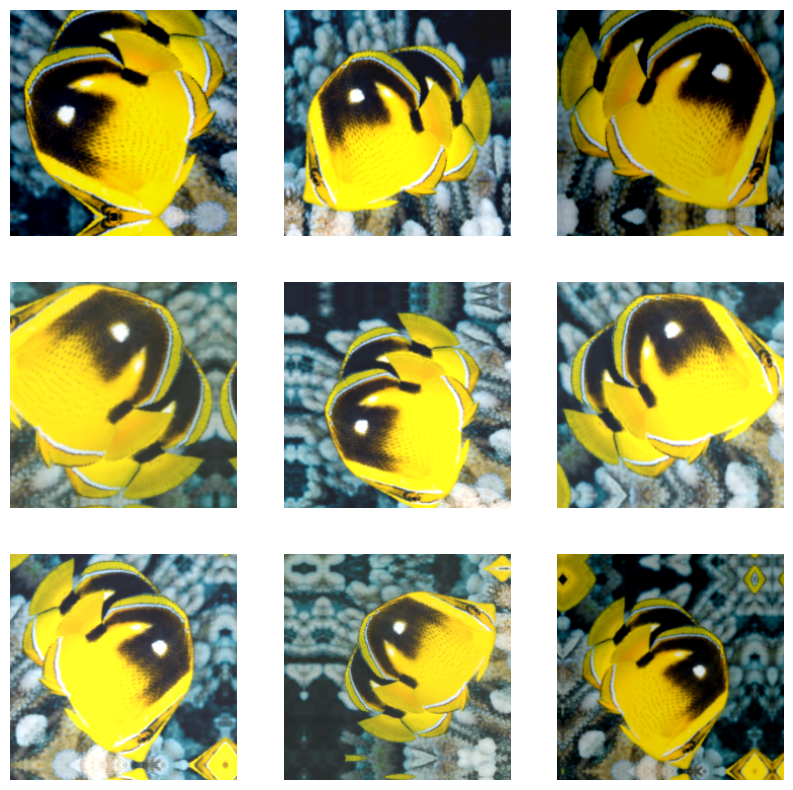

In [4]:
import matplotlib.pyplot as plt

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [5]:
# Image Preprocessing
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

base_model = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Define the inputs and apply augmentation
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Define family output
family_output = tf.keras.layers.Dense(len(family_labels), activation='softmax', name='family')(x)

# Concatenate the family output with the base model output
#family_features = tf.keras.layers.Concatenate()([x, family_output])

# Define genus output, using family features as additional input
genus_hidden = tf.keras.layers.Dense(256, activation='relu')(x)
genus_output = tf.keras.layers.Dense(len(genus_labels), activation='softmax', name='genus')(genus_hidden)

# Concatenate the family and genus outputs with the base model output
#genus_features = tf.keras.layers.Concatenate()([x, family_output, genus_output])

# Define species output, using both family and genus features as additional input
species_hidden = tf.keras.layers.Dense(256, activation='relu')(x)
species_output = tf.keras.layers.Dense(len(species_labels), activation='softmax', name='species')(species_hidden)

# Create the hierarchical model
model = tf.keras.Model(inputs, [family_output, genus_output, species_output])


base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss={
        'family': 'categorical_crossentropy',
        'genus': 'categorical_crossentropy',
        'species': 'categorical_crossentropy'
    },
    metrics=['accuracy']
)

# %%
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 224, 224,  │          0 │ sequential[0][0]  │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 224, 224,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ subtract[0][0]    │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 18)        │     36,882 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 45)        │     11,565 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 57)        │     14,649 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,676,984 (94.14 MB)

 Trainable params: 1,112,184 (4.24 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [6]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss={
        'family': 'categorical_crossentropy',
        'genus': 'categorical_crossentropy',
        'species': 'categorical_crossentropy'
    },
    metrics={
        'family': ['accuracy'],
        'genus': ['accuracy'],
        'species': ['accuracy']
    }
)

In [7]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10


2024-10-22 09:39:13.966222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 236ms/step - family_accuracy: 0.1868 - family_loss: 2.8631 - genus_accuracy: 0.1731 - genus_loss: 3.4593 - loss: 10.0993 - species_accuracy: 0.1574 - species_loss: 3.7774 - val_family_accuracy: 0.4454 - val_family_loss: 1.8213 - val_genus_accuracy: 0.5677 - val_genus_loss: 1.8338 - val_loss: 5.8699 - val_species_accuracy: 0.4772 - val_species_loss: 2.1849
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - family_accuracy: 0.3992 - family_loss: 1.8830 - genus_accuracy: 0.5343 - genus_loss: 1.8350 - loss: 5.8716 - species_accuracy: 0.4822 - species_loss: 2.1531 - val_family_accuracy: 0.5884 - val_family_loss: 1.3792 - val_genus_accuracy: 0.6837 - val_genus_loss: 1.2363 - val_loss: 4.0794 - val_species_accuracy: 0.6478 - val_species_loss: 1.4694
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - family_accuracy: 0.5438 - family_loss: 1.4590 - genus_accuracy: 0.6628 - genus_loss: 1.3094 - loss: 4.2848 - species_accuracy: 0.6170 - species_loss: 1

In [9]:
results = model.evaluate(test_ds)

print(f"Family Acc: {results[4]:.3f}")
print(f"Genus Acc: {results[5]:.3f}")
print(f"Species Acc: {results[6]:.3f}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - family_accuracy: 0.7935 - family_loss: 0.6786 - genus_accuracy: 0.8286 - genus_loss: 0.6021 - loss: 1.9188 - species_accuracy: 0.8296 - species_loss: 0.6384
Family Acc: 0.787
Genus Acc: 0.831
Species Acc: 0.830


In [10]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [13]:
model.compile(
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
  loss="categorical_crossentropy", 
  metrics={
        'family': ['accuracy'],
        'genus': ['accuracy'],
        'species': ['accuracy']
    }
)

In [14]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds)

Epoch 11/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 67s 317ms/step - family_accuracy: 0.7052 - family_loss: 1.0158 - genus_accuracy: 0.7451 - genus_loss: 0.9583 - loss: 3.0375 - species_accuracy: 0.7229 - species_loss: 1.0633 - val_family_accuracy: 0.8218 - val_family_loss: 0.5774 - val_genus_accuracy: 0.8439 - val_genus_loss: 0.5527 - val_loss: 1.7635 - val_species_accuracy: 0.8308 - val_species_loss: 0.6188
Epoch 12/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 55s 302ms/step - family_accuracy: 0.7920 - family_loss: 0.7358 - genus_accuracy: 0.8313 - genus_loss: 0.6333 - loss: 2.0772 - species_accuracy: 0.8111 - species_loss: 0.7081 - val_family_accuracy: 0.8481 - val_family_loss: 0.5043 - val_genus_accuracy: 0.8591 - val_genus_loss: 0.5055 - val_loss: 1.5764 - val_species_accuracy: 0.8439 - val_species_loss: 0.5740
Epoch 13/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 56s 311ms/step - family_accuracy: 0.8267 - family_loss: 0.5999 - genus_accuracy: 0.8607 - genus_loss: 0.5113 - loss: 1.6837 - species_accuracy: 0.8472 - sp

In [15]:
results = model.evaluate(test_ds)

print(f"Family Acc: {results[4]:.3f}")
print(f"Genus Acc: {results[5]:.3f}")
print(f"Species Acc: {results[6]:.3f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - family_accuracy: 0.9224 - family_loss: 0.2563 - genus_accuracy: 0.9147 - genus_loss: 0.3120 - loss: 0.8969 - species_accuracy: 0.9132 - species_loss: 0.3284
Family Acc: 0.920
Genus Acc: 0.912
Species Acc: 0.907


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


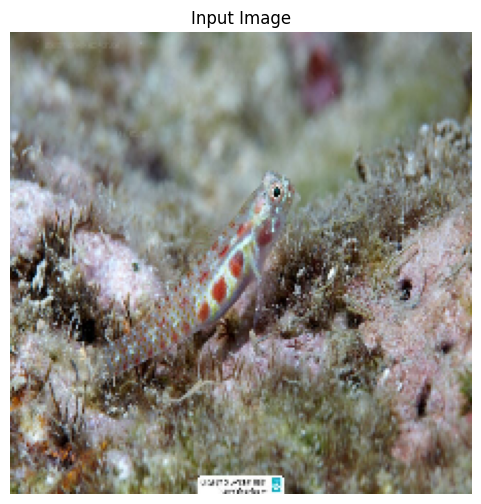

Top 3 Family Predictions:
b'Gobiidae': 0.9920
b'Tripterygiidae': 0.0037
b'Blenniidae': 0.0024

Top 3 Genus Predictions:
b'Eviota': 0.9933
b'Koumansetta': 0.0035
b'Ecsenius': 0.0009

Top 3 Species Predictions:
b'Eviota atriventris': 0.5539
b'Eviota melasma': 0.1355
b'Koumansetta rainfordi': 0.0948


In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image_path, model, family_labels, genus_labels, species_labels, top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], [224, 224]) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species


image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/66367_web_Eviota_melasma_6.jpeg'

top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=3
)